# Image Restoration Workshop 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import io
from skimage.util import random_noise

## Image Degradation Model

We model the observed image `u` as:
$$
u = g * u_0 + n

\\[6pt]

\text{Where:} \\[3pt]
\begin{aligned}
&u_0 : \text{ the original (ideal) image} \\
&g : \text{ the \textbf{Point Spread Function (PSF)} (blur kernel)} \\
&n : \text{ additive Gaussian noise} \\
&* : \text{ convolution operation}
\end{aligned}

\\[10pt]

\text{In the frequency domain:} \\[3pt]
U(f) = G(f) \cdot U_0(f) + N(f)
$$
The PSF describes how a single point is spread in the image (hence its name).

$$

u(x, y)=\sum_{(\tilde{x}, \tilde{y})} u_0(\tilde{x}, \tilde{y}) g(x-\tilde{x}, y-\tilde{y})+n(x, y)=\sum_{(\tilde{x}, \tilde{y})} g(\tilde{x}, \tilde{y}) u_0(x-\tilde{x}, y-\tilde{y})+n(x, y)

$$ 

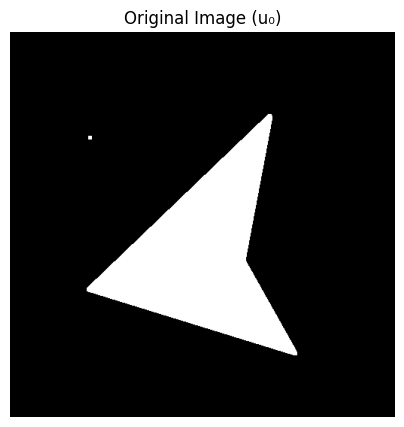

In [2]:
# Load grayscale image
u0 = io.imread("./assets/image1.tif", as_gray=True)

plt.figure(figsize=(5,5))
plt.imshow(u0, cmap='gray')
plt.title("Original Image (u₀)")
plt.axis('off')
plt.show()



- Flou de mise au point : $g_r(x, y)=\frac{1}{\pi r^2} \mathbf{1}_{D_r}(x, y)$ (avec $\mathbf{1}_{D_r}$ l'indicatrice du disque $D(0, r)$ ).
- Gaussian blur (blur due to atmospheric disturbances, for example) $g_\sigma(x, y)=\frac{1}{2 \pi \sigma^2} \exp \left(-\frac{x^2+y^2}{2 \sigma^2}\right)$.
- Motion blur along the horizontal axis: $g_l(x, y)=\frac{1}{2 l}(Y(x+l)-Y(x-l)) \delta(y)$ (où $\delta(y)=1$ if $y=0$ and 0 otherwise).

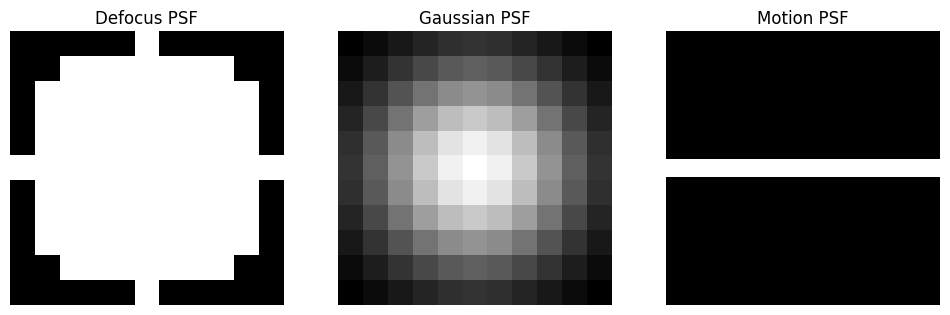

In [3]:
def defocus_psf(radius=5):
    """Defocus (disk) blur kernel"""
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    psf = np.zeros((2*radius+1, 2*radius+1))
    psf[mask] = 1
    return psf / psf.sum()

def motion_psf(length=15):
    """Horizontal motion blur"""
    psf = np.zeros((length, length))
    psf[length//2, :] = 1
    return psf / psf.sum()

def gaussian_psf(sigma=3, size=11):
    """Gaussian blur kernel"""
    ax = np.arange(-size//2 + 1., size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return psf / psf.sum()

# Visualize kernels
fig, axs = plt.subplots(1,3, figsize=(12,4))
for ax, kernel, title in zip(axs, [defocus_psf(), gaussian_psf(), motion_psf()],
                             ['Defocus PSF', 'Gaussian PSF', 'Motion PSF']):
    ax.imshow(kernel, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.show()


In [4]:
def degrade_image(image, psf, noise_sigma=0):
    """Apply convolution blur and optional Gaussian noise"""
    blurred = convolve2d(image, psf, mode='same', boundary='symm')
    if noise_sigma > 0:
        noisy = random_noise(blurred, var=(noise_sigma**2))
        return noisy
    return blurred


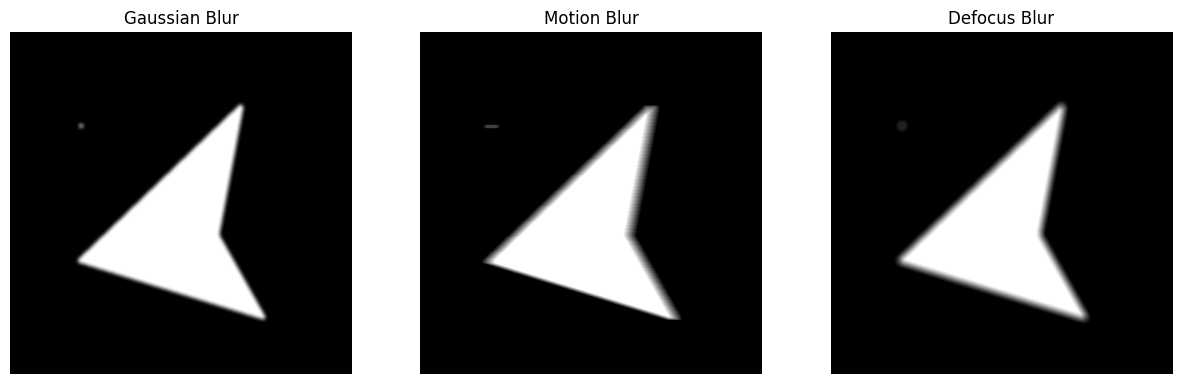

In [5]:
# Example degradations
psf_gauss = gaussian_psf(sigma=3)
psf_motion = motion_psf(20)
psf_defocus = defocus_psf(8)

images = {
    "Gaussian Blur": degrade_image(u0, psf_gauss),
    "Motion Blur": degrade_image(u0, psf_motion),
    "Defocus Blur": degrade_image(u0, psf_defocus)
}

plt.figure(figsize=(15,5))
for i, (title, img) in enumerate(images.items()):
    plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.show()

## Direct Deconvolution

A linear convolution assumes the blur is *shift-invariant* and *linear*.
However, real optical blur (e.g. **bokeh**) depends on:
- depth of field,
- lens aperture shape,
- object distance.

Hence, real blur is **spatially variant**, not purely convolutional.


We start from the linear degradation model (without noise):

$$
u=g * u_0
$$


Applying the Fourier transform gives:

$$
U(f)=G(f) \cdot U_0(f)
$$


To recover the original image $u_0$ :

$$
U_0(f)=\frac{U(f)}{G(f)}
$$


Finally, we get the reconstructed image by inverse Fourier transform:

$$
\hat{u}_0=\mathcal{F}^{-1}\left(\frac{U(f)}{G(f)}\right)
$$

In [14]:
def inverse_filter(u, psf, eps=0):
    U = np.fft.fft2(u)
    G = np.fft.fft2(psf, s=u.shape)
    H = np.conj(G) / (np.abs(G)**2 + eps)
    U0_est = np.real(np.fft.ifft2(U * H))
    return np.clip(U0_est, 0, 1)
    

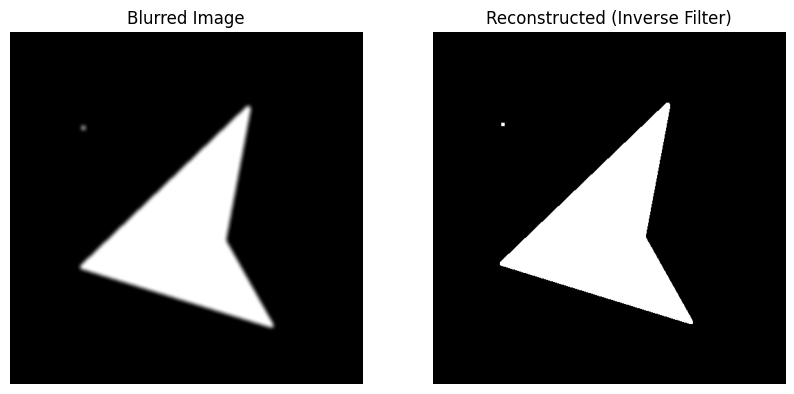

In [15]:
blurred = degrade_image(u0, psf_gauss, noise_sigma=0)
restored = inverse_filter(blurred, psf_gauss)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(restored, cmap='gray')
plt.title('Reconstructed (Inverse Filter)')
plt.axis('off')
plt.show()

## Wiener Filter



We start again from the \textbf{image degradation model}:
$$

u(x, y) = (g * u_0)(x, y) + n(x, y) 
$$
where:

- $u_0$: original image (unknown)
- $g$: PSF (known blur)
- $n$: additive Gaussian noise (zero mean, variance $\sigma^2$)
- $u$: observed image


In the $\textbf{Fourier domain}:$
$$
U(f) = G(f) \cdot U_0(f) + N(f)

$$
We want to find a filter H(f) such that:
$$
V(f) = H(f) \cdot U(f)
$$
is a good estimate of the original $U_0(f)$.
$$
H(f) = \frac{G^*(f)}{|G(f)|^2 + K}
$$
where      $$ \ K  =  \frac{S_N(f)}{S_{U_0}(f)}$$


In [ ]:
def wiener_filter(u, psf, K=0.01):
    U = np.fft.fft2(u)
    G = np.fft.fft2(psf, s=u.shape)
    H = np.conj(G) / (np.abs(G)**2 + K)
    U0_est = np.real(np.fft.ifft2(U * H))
    return np.clip(U0_est, 0, 1)

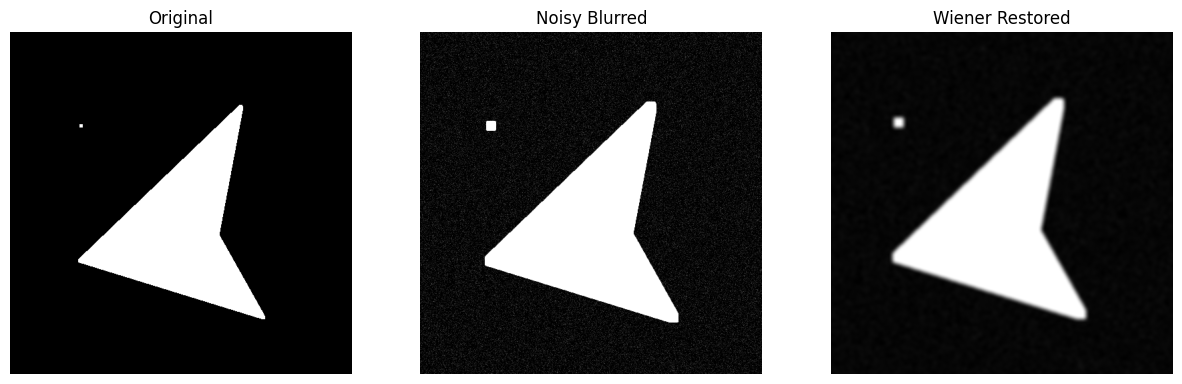

In [55]:
noisy_blur = degrade_image(u0, psf_gauss, noise_sigma=0.1)
wiener_restored = wiener_filter(noisy_blur, psf_gauss, K=100)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_blur, cmap='gray'); plt.title("Noisy Blurred"); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_restored, cmap='gray'); plt.title("Wiener Restored"); plt.axis('off')
plt.show()

## Improving A blurred image with the Wiener Filter

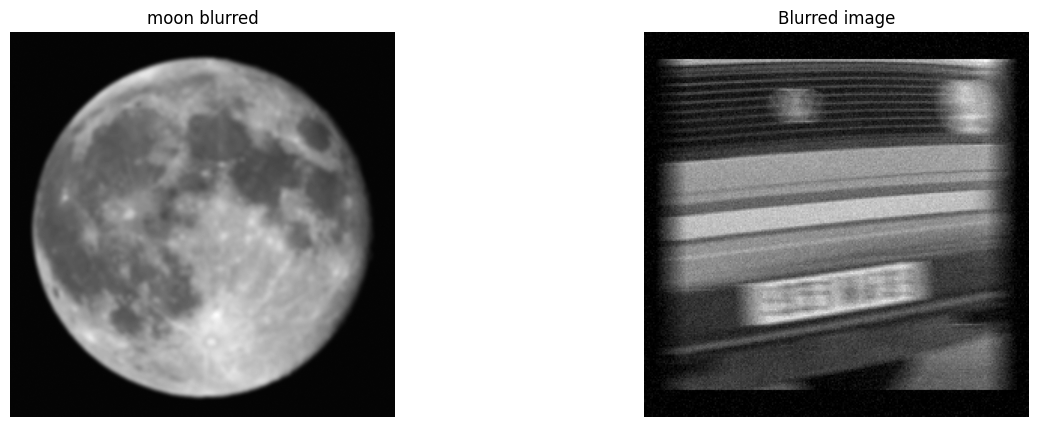

In [31]:
moon = io.imread("./assets/lune.tif", as_gray=True)
blurred_image = io.imread("./assets/floue.tif", as_gray=True)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(moon, cmap='gray')
plt.title("moon blurred")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred image")
plt.axis('off')
plt.show()

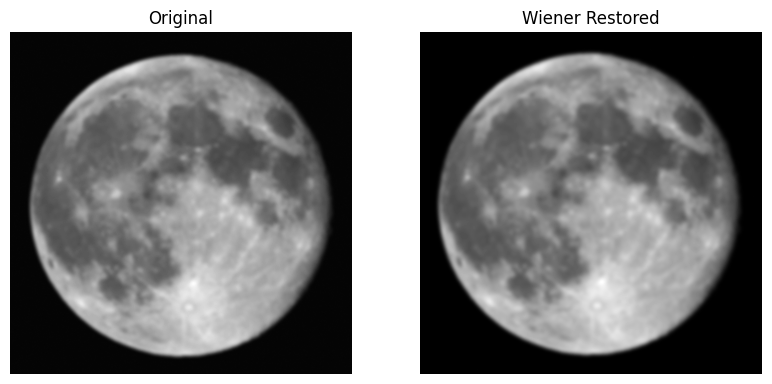

In [64]:
wiener_restored_moon = wiener_filter(moon, defocus_psf(5), K=500)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(moon, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(wiener_restored_moon, cmap='gray'); plt.title("Wiener Restored"); plt.axis('off')
plt.show()

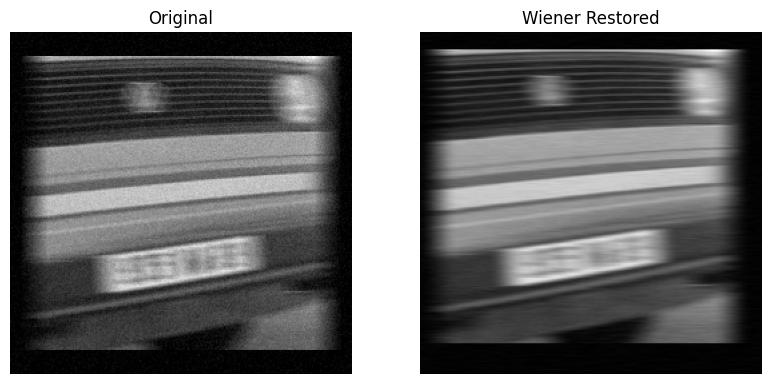

In [83]:
wiener_restored_blurred = wiener_filter(blurred_image, motion_psf(10), K=1e7)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(blurred_image, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(wiener_restored_blurred, cmap='gray'); plt.title("Wiener Restored"); plt.axis('off')
plt.show()